In [1]:
%pip install nlp

     ---------------------------------------- 1.7/1.7 MB 1.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DistilBertForSequenceClassification

In [18]:
class RegressionModel(DistilBertForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
    
    def compute_rse_loss(self, predictions, labels):
        mse_predictions_labels = torch.nn.functional.mse_loss(predictions.view(-1), labels.view(-1).float())
        mean_labels = torch.mean(labels.float())
        mse_labels_mean = torch.nn.functional.mse_loss(labels.view(-1).float(), mean_labels.expand_as(labels).view(-1))
        rse = mse_predictions_labels / mse_labels_mean
        return rse
    
    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None, labels=None):
        outputs = self.distilbert(
                            input_ids=input_ids,
                            attention_mask=attention_mask,
                            )

        predictions = self.classifier(outputs.last_hidden_state[:, 0])
        
        if labels is not None:
            # Calculate the RSE loss if labels are provided
            loss = self.compute_rse_loss(predictions, labels)
            return loss, predictions
        else:
            return predictions

In [31]:
import nlp
import numpy as np
import scipy as sp
import torch
import transformers

import shap

# load a BERT sentiment analysis model
model = DistilBertForSequenceClassification.from_pretrained('yiyanghkust/finbert-pretrain',num_labels=1).cuda()
tokenizer = AutoTokenizer.from_pretrained('yiyanghkust/finbert-pretrain')

# define a prediction function
def f(x):
    tv = torch.tensor(
        [
            tokenizer.encode(v, padding="max_length", max_length=300, truncation=True)
            for v in x
        ]
    ).cuda()
    outputs = model(tv)[0].detach().cpu().numpy()
    return outputs


# build an explainer using a token masker
explainer = shap.Explainer(f, tokenizer, approximate=True)

# explain the model's predictions on IMDB reviews
imdb_train = nlp.load_dataset("imdb")["train"]
shap_values = explainer(imdb_train['text'][:10], fixed_context=1)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['transformer.layer.10.attention.k_lin.bias', 'transformer.layer.0.ffn.lin1.weight', 'transformer.layer.5.attention.v_lin.bias', 'pre_classifier.bias', 'transformer.layer.6.attention.v_lin.weight', 'transformer.layer.10.attention.q_lin.weight', 'transformer.layer.7.attention.v_lin.bias', 'transformer.layer.2.sa_layer_norm.bias', 'transformer.layer.9.attention.k_lin.bias', 'transformer.layer.11.attention.q_lin.weight', 'transformer.layer.2.attention.q_lin.weight', 'transformer.layer.7.sa_layer_norm.weight', 'transformer.layer.5.ffn.lin1.bias', 'transformer.layer.8.output_layer_norm.weight', 'transformer.layer.0.attention.v_lin.bias', 'transformer.layer.7.ffn.lin2.bias', 'transformer.layer.5.ffn.lin1.weight', 'transformer.layer.1.sa_layer_norm.bias', 'transformer.layer.9.attention.q_lin.weight', 'transformer.layer.1.attention.v_lin.

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|█         | 1/10 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███       | 3/10 [09:23<17:38, 151.21s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|████      | 4/10 [13:50<19:56, 199.38s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 5/10 [17:04<16:28, 197.72s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 6/10 [20:08<12:51, 192.79s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 7/10 [25:09<11:26, 228.86s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 8/10 [28:21<07:13, 216.88s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|█████████ | 9/10 [33:29<04:05, 245.43s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 10/10 [38:43<00:00, 266.74s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 11it [43:52, 263.29s/it]                        


In [34]:
shap.plots.text(shap_values[0])

In [32]:
shap_values.abs.sum(0)

.values =
array([[0.0063135 ],
       [0.00418687],
       [0.00409485],
       ...,
       [0.00026998],
       [0.00026998],
       [0.00026998]])

.base_values =
array([-0.23056644])

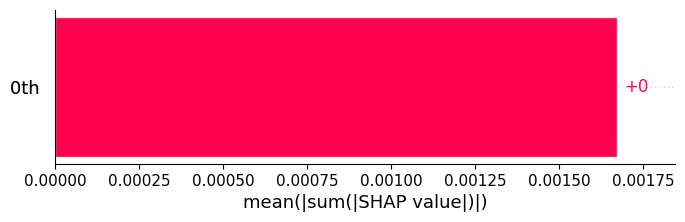

In [33]:
shap.plots.bar(shap_values.abs.sum(0), max_display=10)

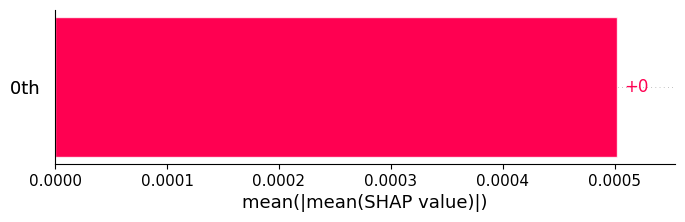

In [36]:
shap.plots.bar(shap_values.mean(0), max_display=10)

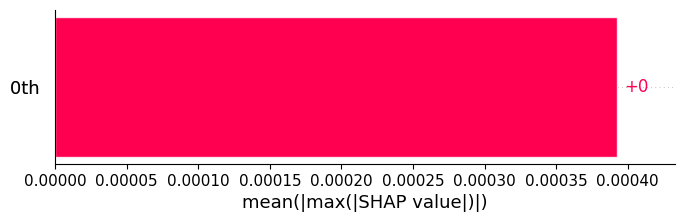

In [23]:
shap.plots.bar(shap_values.abs.max(0))